In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path= '/content/drive/MyDrive/thesis/code'
os.chdir(path)

In [1]:
import os
path = "/workspace"
os.chdir(path)
import sys

In [2]:

import sys
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, Markdown

In [3]:
def highlight_words(text, ranges):
    words = text.split()
    highlighted_text = []
    for i, word in enumerate(words):
        if any(start <= i < end for start, end in ranges):
            highlighted_text.append(f"\033[43m{word}\033[0m")  # yellow background
        else:
            highlighted_text.append(word)
    text = " ".join(highlighted_text)
    for i in range(0, len(text), 500):
        print(text[i:i+500])

def print_instance(instance):
    print('\033[1mPREDICT PROMPT:\033[0m',instance['predict_prompt'])
    print('\033[1mPREDICT ANSWER:\033[0m',instance['predict_answer'],'\n')
    print('\033[1mEXPLAIN PROMPT:\033[0m',instance['explain_prompt'])
    print('\033[1mEXPLAIN ANSWER:\033[0m',instance['explain_answer'],'\n')
    print('\033[1mEXPLAIN PREDICT PROMPT:\033[0m',instance['explain_predict_prompt'])
    print('\033[1mEXPLAIN PREDICT ANSWER:\033[0m',instance['explain_predict_answer'],'\n')

def print_attack(attack):
    print('\033[1mORIGINAL INPUT:\033[0m', attack['original_text'], '\n\033[1mSCORE:\033[0m', attack['original_score'] )
    print('\033[1mPERTURBATION:\033[0m', attack['perturbed_text'], '\n\033[1mSCORE:\033[0m', attack['perturbed_score'])
    print(attack['result_type'], 'Attack')

In [4]:
os.chdir(path + '/eraserbenchmark-master')
from rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

#**Datasets**

##**IMDB**

In [5]:
movies_data_root = path + '/eraserbenchmark-master/data/movies'
movies_documents = load_documents(movies_data_root)
movies = annotations_from_jsonl(os.path.join(movies_data_root, 'test.jsonl'))

In [6]:
instance = movies[0]
text =  " ".join(word for sentence in movies_documents[instance.annotation_id] for word in sentence)
ranges = []
for ev in next(iter(instance.evidences)):
    ranges.append((ev.start_token, ev.end_token))
highlight_words(text, ranges)

there may not be a critic alive who harbors as much affection for shlock monster movies as i do . i delighted in the sneaky - smart entertainment of ron underwood 's big - underground - worm yarn tremors ; i even giggled at last year 's critically - savaged big - underwater - snake yarn anaconda . something about these films causes me to lower my inhibitions and retu
rn to the saturday afternoons of my youth , spent in the company of ghidrah , the creature from the black lagoon and the blob . deep rising , a big - undersea - serpent yarn , does n't quite pass the test . sure enough , all the modern monster movie ingredients are in place : a conspicuously multi - ethnic / multi - national collection of bait . .. excuse me 
, characters ; an isolated location , here a derelict cruise ship in the south china sea ; some comic relief ; a few cgi - enhanced gross - outs ; and at least one big explosion . there are too - cheesy - to - be - accidental elements , like a sleazy shipping magnate 

##**e-SNLI**

In [7]:
esnli_data_root = path + '/eraserbenchmark-master/data/esnli'
esnli_documents = load_documents(esnli_data_root)
esnli = annotations_from_jsonl(os.path.join(esnli_data_root, 'test.jsonl'))
esnli[:] = [instance for instance in esnli if instance.classification != 'neutral']  #filter out neutral for binary classification

In [8]:
instance = esnli[1]
hypothesis = " ".join(word for sentence in esnli_documents[instance.annotation_id+'_hypothesis'] for word in sentence)
premise = " ".join(word for sentence in esnli_documents[instance.annotation_id+'_premise'] for word in sentence)
premise_evs = []
hypothesis_evs = []
for ev in next(iter(instance.evidences)):
    if ev.docid.split('_')[1] == 'hypothesis':
        hypothesis_evs.append((ev.start_token, ev.end_token))
    else:
        premise_evs.append((ev.start_token, ev.end_token))
print('Hypothesis:')
highlight_words(hypothesis, hypothesis_evs)
print('Premise:')
highlight_words(premise, premise_evs)

Hypothesis:
There is a man wearing cloths.
Premise:
A man in green pants and blue shirt pushing a cart.


#**1. INTROSPECTIONS - SELF GENERATED COUNTERFACTUALS**

###**Task: IMDB**

**Experiment:**

In [13]:
os.chdir(path+'/introspections/movie_introspections/Llama-3.2-1B-Instruct/results/analysis')
conn = sqlite3.connect("analysis_m-llama3_y-none_d-imdb_p-test_t-counterfactual_c-_s-0.sqlite")
df = pd.read_sql_query("SELECT * FROM Counterfactual", conn)
conn.close()
print_instance(df.iloc[0])

PREDICT PROMPT: You are a sentiment classifier. Answer ONLY "positive" or "negative". Do not explain the answer. What is the sentiment of the user's paragraph?
Paragraph: there may not be a critic alive who harbors as much affection for shlock monster movies as i do . i delighted in the sneaky - smart entertainment of ron underwood 's big - underground - worm yarn tremors ; i even giggled at last year 's critically - savaged big - underwater - snake yarn anaconda . something about these films causes me to lower my inhibitions and return to the saturday afternoons of my youth , spent in the company of ghidrah , the creature from the black lagoon and the blob . deep rising , a big - undersea - serpent yarn , does n't quite pass the test . sure enough , all the modern monster movie ingredients are in place : a conspicuously multi - ethnic / multi - national collection of bait . .. excuse me , characters ; an isolated location , here a derelict cruise ship in the south china sea ; some com

**Evaluation:**

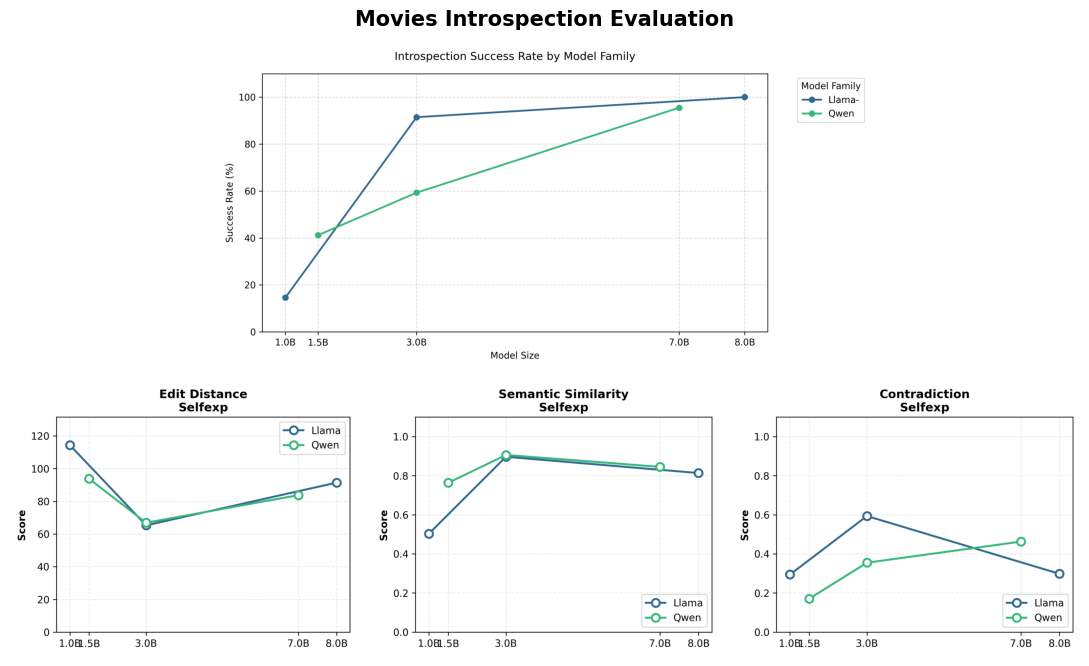

In [14]:
fig = plt.figure(figsize=(11, 7))
fig.suptitle("Movies Introspection Evaluation", fontsize=15, fontweight='bold')
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(mpimg.imread(path + '/results/movie_results/Introspection.png'))
ax1.axis('off')
files = ["edit_distance_selfexp.png","semantic_similarity_selfexp.png","contradiction_selfexp.png"]
for i, f in enumerate(files):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(mpimg.imread(path + '/results/movie_results/' + f))
    ax.axis('off')
plt.tight_layout()
plt.show()

###**Task: e-SNLI**

**Experiment:**

In [15]:
os.chdir(path+'/introspections/esnli_introspections/Llama-3.2-3B-Instruct/results/analysis')
conn = sqlite3.connect("analysis_m-llama3_y-none_d-rte_p-test_t-counterfactual_c-_s-0.sqlite")
df = pd.read_sql_query("SELECT * FROM Counterfactual", conn)
conn.close()
print_instance(df.iloc[1])

PREDICT PROMPT: Does the statement "A man in green pants and blue shirt pushing a cart." entail from the following paragraph? Answer either "yes" for entailment or "no" for no entailment. Do not explain the answer.
Paragraph: There is a man wearing cloths.
PREDICT ANSWER: no 

EXPLAIN PROMPT: Edit the following paragraph such that the statement "A man in green pants and blue shirt pushing a cart." entails from it. Make as few edits to the paragraph as possible. Do not explain the answer.
Paragraph: There is a man wearing cloths.
EXPLAIN ANSWER: There is a man in green pants and a blue shirt, pushing a cart. 

EXPLAIN PREDICT PROMPT: Does the statement "A man in green pants and blue shirt pushing a cart." entail from the following paragraph? Answer either "yes" for entailment or "no" for no entailment. Do not explain the answer.
Paragraph: There is a man in green pants and a blue shirt, pushing a cart.
EXPLAIN PREDICT ANSWER: No. 



**Evaluation:**

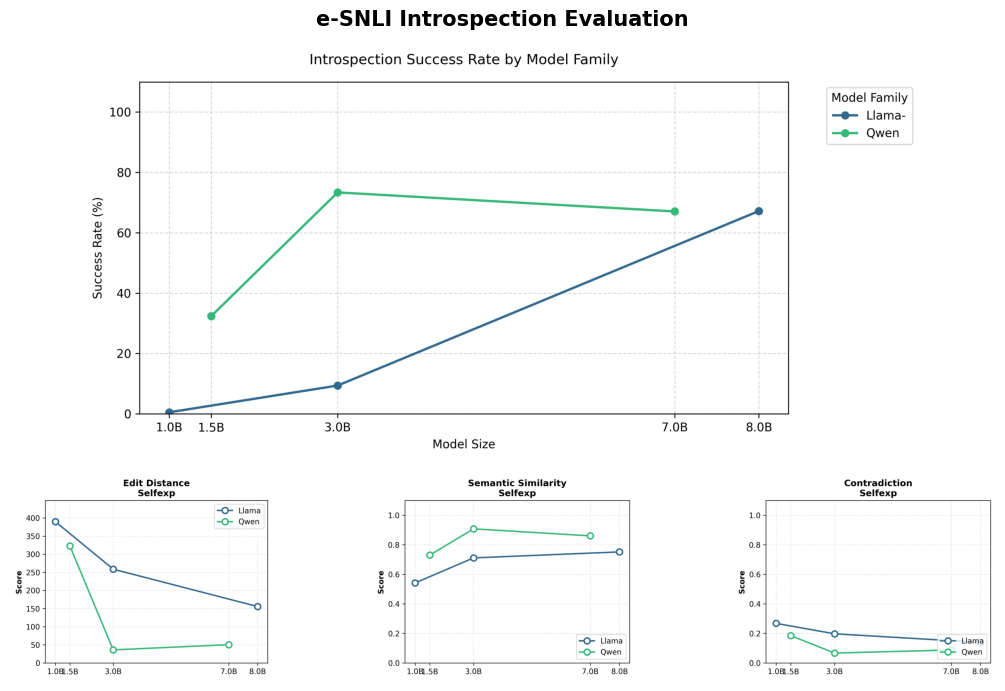

In [16]:
fig = plt.figure(figsize=(11, 7))
fig.suptitle("e-SNLI Introspection Evaluation", fontsize=15, fontweight='bold')
gs = fig.add_gridspec(2, 3, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, :])
img_top = mpimg.imread(path + '/results/esnli_results/Introspection.png')
ax1.imshow(img_top)
ax1.axis('off')

files = ["edit_distance_selfexp.png","semantic_similarity_selfexp.png","contradiction_selfexp.png"]
for i, f in enumerate(files):
    ax = fig.add_subplot(gs[1, i])
    img = mpimg.imread(path + '/results/esnli_results/' + f)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


#**2. ADVERSARIAL ATTACKS - TEXTATTACK**

###**Task: IMDB**

**Experiment:**

In [17]:
os.chdir(path+'/attacks/movie_attacks')
attack = pd.read_csv("Llama-3.2-1B-Instruct_PWWSRen2019.csv")
print_attack(attack.iloc[0])

ORIGINAL INPUT: there may not be a critic alive who harbors as much affection for shlock monster movies as i do . i delighted in the sneaky - smart entertainment of ron underwood 's big - underground - worm yarn tremors ; i even giggled at last year 's critically - savaged big - underwater - snake yarn anaconda . something about these films causes me to lower my inhibitions and return to the saturday afternoons of my youth , spent in the company of ghidrah , the creature from the black lagoon and the blob . deep rising , a big - undersea - serpent yarn , does n't quite [[pass]] the test . sure enough , all the modern monster movie ingredients are in place : a conspicuously multi - ethnic / multi - national collection of bait . .. excuse me , characters ; an isolated location , here a derelict cruise ship in the south china sea ; some comic relief ; a few cgi - enhanced gross - outs ; and at least one big explosion . there are too - cheesy - to - be - accidental elements , like a sleazy

**Evaluation:**

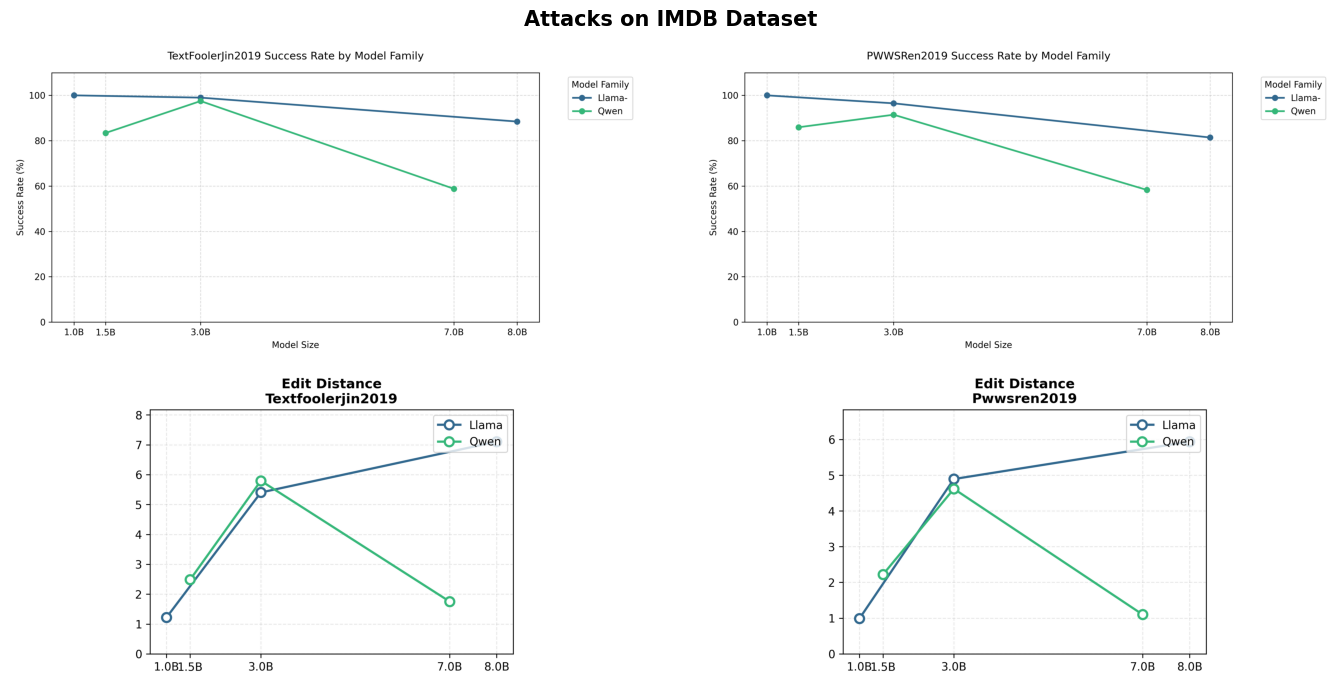

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14,7))  # 1 row, 2 columns
fig.suptitle("Attacks on IMDB Dataset", fontsize=15, fontweight='bold')
axes[0][0].imshow(mpimg.imread(path+'/results/movie_results/TextFoolerJin2019.png'))
axes[0][0].axis('off')
axes[0][1].imshow(mpimg.imread(path+'/results/movie_results/PWWSRen2019.png'))
axes[0][1].axis('off')
axes[1][0].imshow(mpimg.imread(path+'/results/movie_results/edit_distance_TextFoolerJin2019.png'))
axes[1][0].axis('off')
axes[1][1].imshow(mpimg.imread(path+'/results/movie_results/edit_distance_PWWSRen2019.png'))
axes[1][1].axis('off')
plt.tight_layout()
plt.show()


###**Task: e-SNLI**

**Experiment:**

In [21]:
os.chdir(path+'/attacks/esnli_attacks')
attack = pd.read_csv("Llama-3.2-1B-Instruct_TextFoolerJin2019.csv")
print_attack(attack.iloc[0])

ORIGINAL INPUT: A woman is smoking a cigarette. [[A]] [[man]] in [[green]] [[pants]] and blue [[shirt]] [[pushing]] a [[cart]]. 
SCORE: 0.2185766696929931
PERTURBATION: A woman is smoking a cigarette. [[paras]] [[comrade]] in [[verte]] [[robes]] and blue [[gown]] [[press]] a [[railcar]]. 
SCORE: 0.2672018408775329
Failed Attack


**Evaluation:**

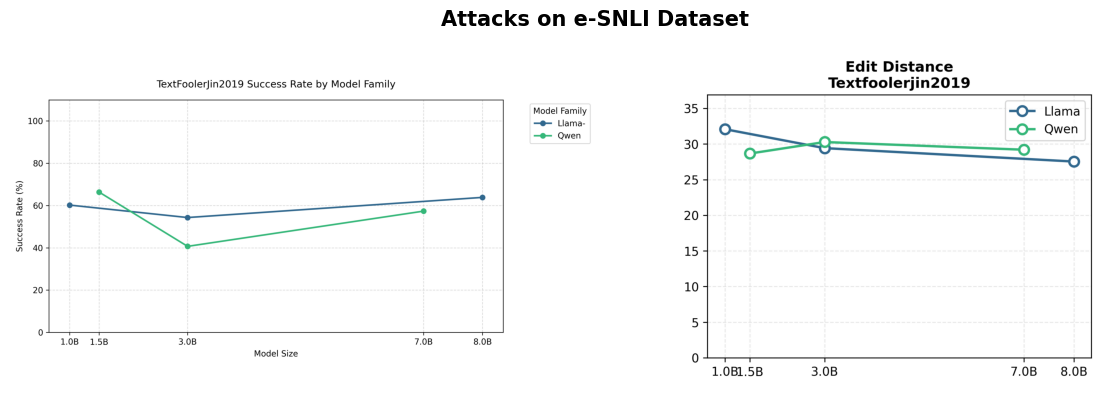

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("Attacks on e-SNLI Dataset", fontsize=15, fontweight='bold')
axes[0].imshow(mpimg.imread(path+'/results/esnli_results/TextFoolerJin2019.png'))
axes[0].axis('off')
axes[1].imshow(mpimg.imread(path+'/results/esnli_results/edit_distance_TextFoolerJin2019.png'))
axes[1].axis('off')
plt.tight_layout()
plt.show()

#**Counterfactual Edits Against Human-Annotated Feature Importance**

**Precision**: What percent of the perturbations in the input are *evidence* supported?
 - TP = deleted/replaced/inserted token inside a human span
 - FP = deleted/replaced/inserted token outside of a human span


 $$
\text{Precision} = \frac{T_P}{T_P + F_P}
$$

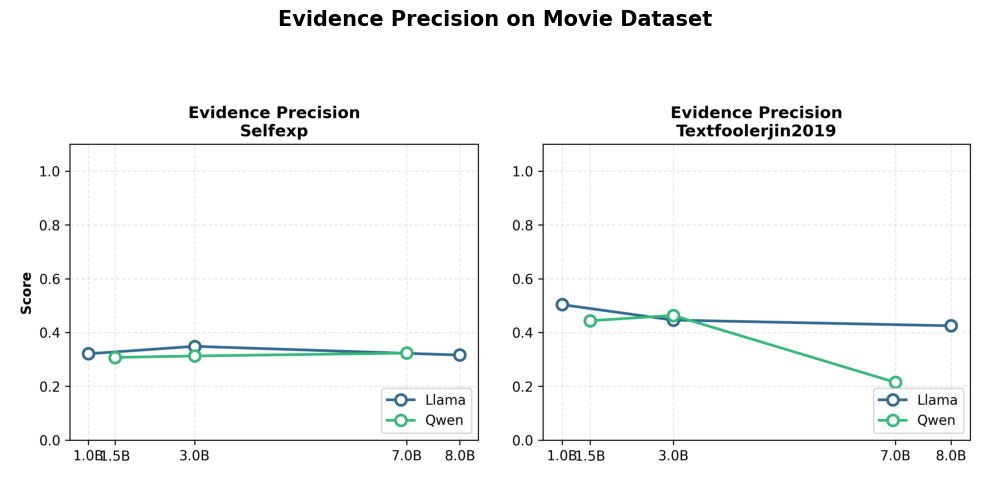

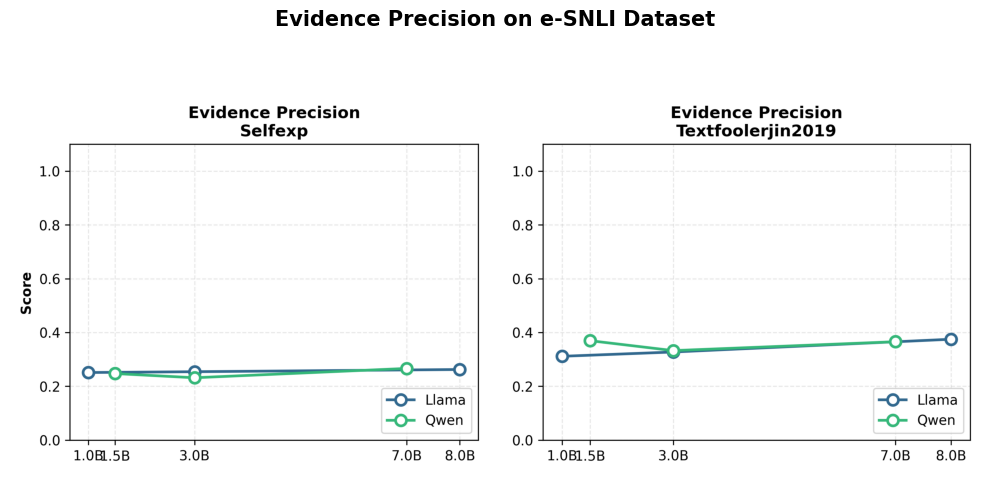

In [29]:
files = ["evidence_precision_selfexp.png","evidence_precision_TextFoolerJin2019.png"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Evidence Precision on Movie Dataset", fontsize=15, fontweight='bold')
for ax, f in zip(axes, files):
    ax.imshow(mpimg.imread(path + "/results/movie_results/" + f))
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Evidence Precision on e-SNLI Dataset", fontsize=15, fontweight='bold')
for ax, f in zip(axes, files):
    ax.imshow(mpimg.imread(path + "/results/esnli_results/" + f))
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


 **Recall**: what percent of the evidence tokens where perturbed ?
 - TP = deleted/replaced evidence token
 - FN = reproduced unchanged evidence token

 $$
\text{Recall} = \frac{T_P}{T_P + F_N}
$$

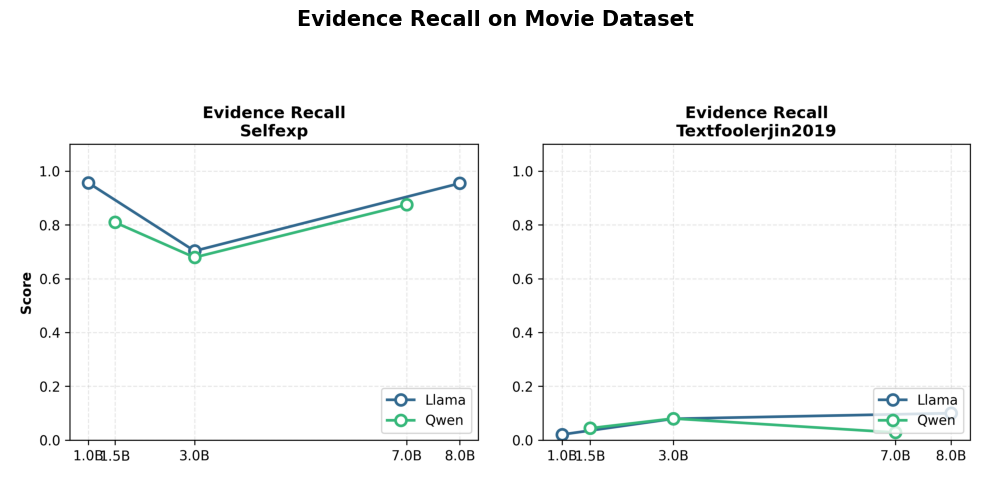

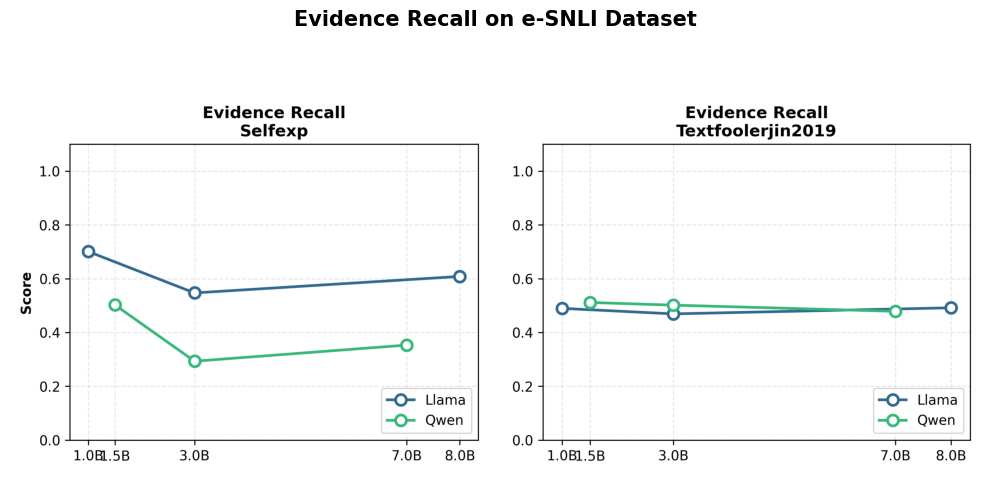

In [31]:
files = ["evidence_recall_selfexp.png","evidence_recall_TextFoolerJin2019.png"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Evidence Recall on Movie Dataset", fontsize=15, fontweight='bold')
for ax, f in zip(axes, files):
    ax.imshow(mpimg.imread(path + "/results/movie_results/" + f))
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Evidence Recall on e-SNLI Dataset", fontsize=15, fontweight='bold')
for ax, f in zip(axes, files):
    ax.imshow(mpimg.imread(path + "/results/esnli_results/" + f))
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


#**Consistency of Model Counterfactuals**


$$
\text{Heatmap}(i, j) = \text{Recall}(i, j) = \frac{|T_i \cap T_j|}{|T_j|}
$$

where:
- Ti = Tokens perturbed by method i
 - Tj = Tokens perturbed by method j

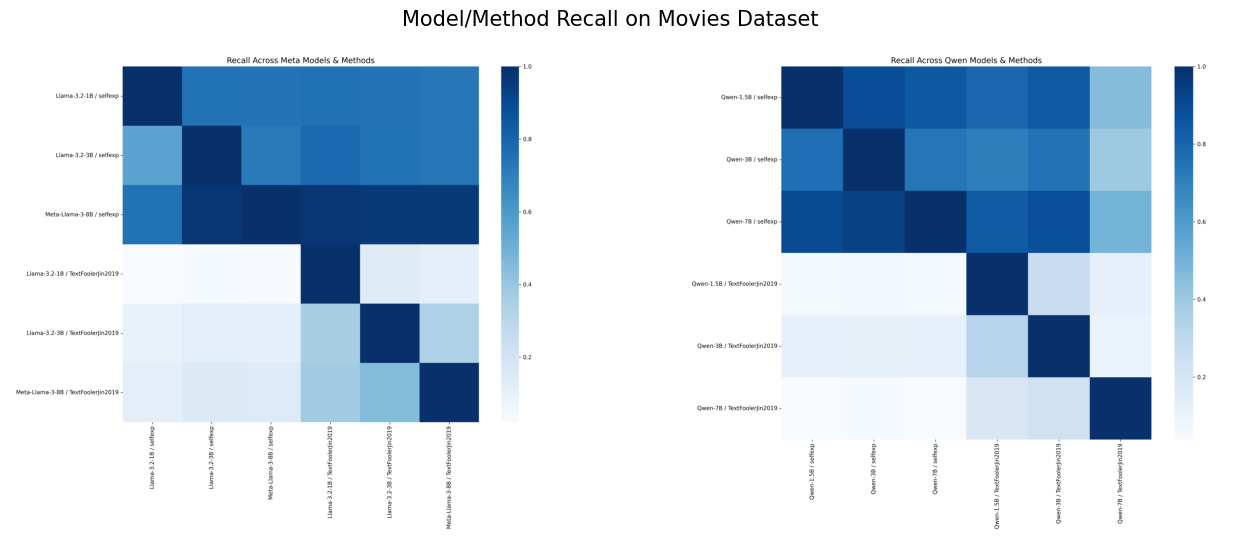

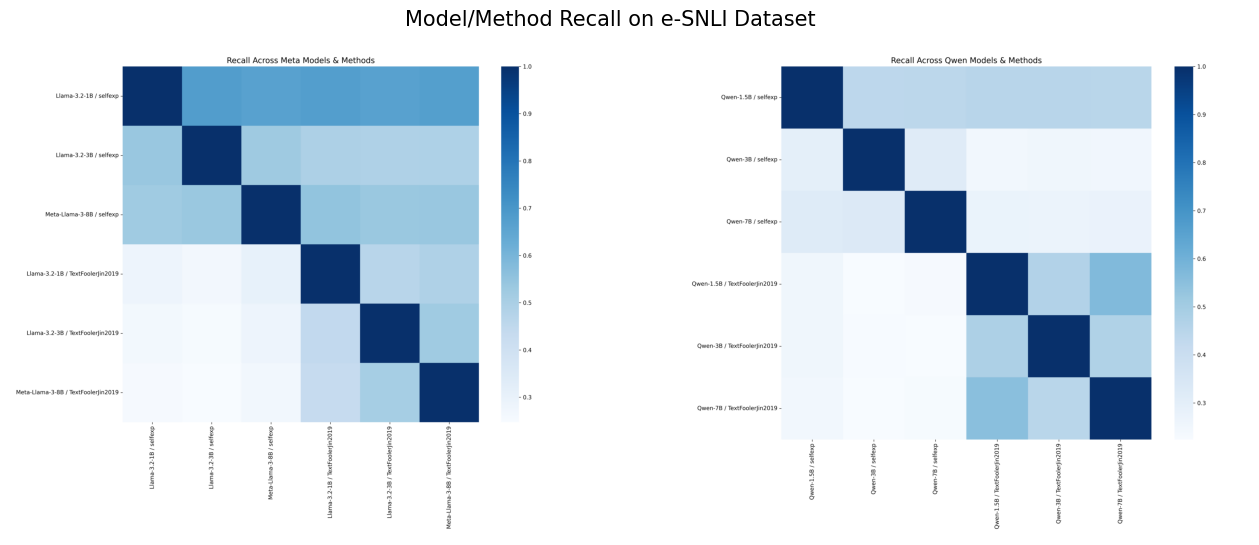

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Model/Method Recall on Movies Dataset", fontsize=15, y='0.85')
axes[0].imshow(mpimg.imread(path+'/results/movie_results/heatmap_Meta.png'))
axes[0].axis('off')
axes[1].imshow(mpimg.imread(path+'/results/movie_results/heatmap_Qwen.png'))
axes[1].axis('off')
fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Model/Method Recall on e-SNLI Dataset", fontsize=15, y='0.85')
axes[0].imshow(mpimg.imread(path+'/results/esnli_results/heatmap_Meta.png'))
axes[0].axis('off')
axes[1].imshow(mpimg.imread(path+'/results/esnli_results/heatmap_Qwen.png'))
axes[1].axis('off')
plt.show()

#**Conclusions**

**Introspections**:

Movies:
 - Qwen: improved moderately, low quality counterfactuals
 - Llama: improved dramatically, slight tradeoff in quality

e-SNLI:
 - Qwen > Llama in quality
 - Qwen saturated
 - Llama scaled better

overall:
  - Bigger models -> better in producing faithful counterfactual edits.
  - Llama scaled better

**Attacks**:

 - Bigger models -> More robust
 - Llama scaled more token perturbations necessary.

 (by definition, adversarial attacks generate high similarity/low contradiction perturbations)


#**LLMS - HUMANS**:
(e-SNLI in movies very low quality)

**Precision**:
 - Introspections: Stable across both tasks
 - Attacks:
  - Movies: Both decline
  - e-SNLI: Stable after 3B

**Recall**:
(movies evidences >> attacked tokens)
 - Movies: Llama covered more of the evidences as its size grew.
 - e-SNLI:
  - Same introspection behavior. Llama better maintains alignment.
  - Contrasting vulnerabilities. Llama is susceptible  when more evidence-related tokens are changed, while Qwen the opposite.

#**Cross-LLM Overlap**:


**Movies**
 - Llama (first three lines): Attack's recall on introspections consistently reflect the introspection's edit-distance
 - Qwen: Bad quality introspections.

**e-SNLI**
1. Llama (first three lines): The attacks consistenty perturb the same percent as the original recall of the introspection.
2. No other patterns

